Proyecto realizado para el curso fundamentos de Spark para Big Data basado en los contenidos del curso Spark de Udacity:

https://www.udacity.com/course/learn-spark-at-udacity--ud2002

En este notebook se replican con el SQL API de Spark los resultados obtenidos con el DataFrame API, así que para mejor entendimiento recomendamos revisar primero el otro Notebook:

https://github.com/EusseJhoan/ProyectoPlatziSpark/blob/main/SparkBigData.ipynb

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession \
    .builder \
    .appName("ProyectoSQL") \
    .getOrCreate()

In [ ]:
path = "drive/MyDrive/sparkify_log_small.json" #Ruta de archivo de donde se cargara datos
user_log = spark.read.json(path) #cargar los datos (JSON)

In [ ]:
#Toca usarlo para poder usar queries de SQL en pySpark, se pone en argumento el nombre que se dará a la tabla para llamarla en FROM
user_log.createOrReplaceTempView("user_log_table")

In [ ]:
spark.sql("""
SELECT DISTINCT page
FROM user_log_table
ORDER BY page
""").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [ ]:
#Filtra para el usuario 1046 el registro con esas 4 columnas
spark.sql("""
SELECT userId, firstname, page, song
FROM user_log_table
WHERE userId == "1046"
""").collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

In [ ]:
#Funcion para obtener la hora de una columna
spark.udf.register("get_hour",lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

#Recordar que en la lógica de DataFrames usabamos
#get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

<function __main__.<lambda>(x)>

In [ ]:
spark.sql("""
              SELECT *, get_hour(ts) AS hour
              FROM user_log_table
          """).head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='22')

In [ ]:
#Filter rows with WHERE condition, group by hour, counting rows in eacch group and order by hour
songs_in_hour= spark.sql("""
              SELECT get_hour(ts) AS hour, COUNT(*) AS count
              FROM user_log_table
              WHERE page == "NextSong"
              GROUP BY hour
              ORDER BY cast(hour as int)
          """)

songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  456|
|   1|  454|
|   2|  382|
|   3|  302|
|   4|  352|
|   5|  276|
|   6|  348|
|   7|  358|
|   8|  375|
|   9|  249|
|  10|  216|
|  11|  228|
|  12|  251|
|  13|  339|
|  14|  462|
|  15|  479|
|  16|  484|
|  17|  430|
|  18|  362|
|  19|  295|
+----+-----+
only showing top 20 rows



In [ ]:
songs_in_hour_pd = songs_in_hour.toPandas() #convert to pandas dataframe
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour) #convert elements of hour column in numbers type (a good practice to apply always)

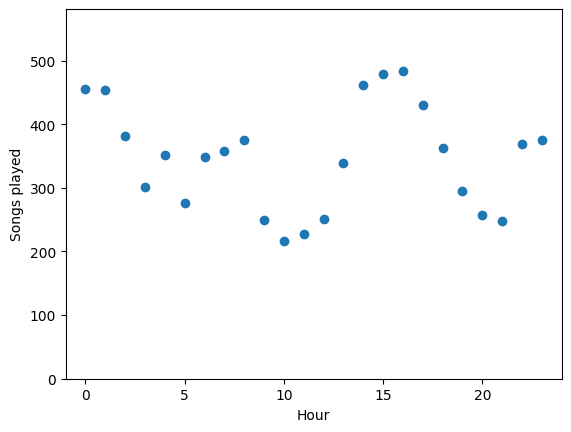

In [ ]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [ ]:
user_log_valid= spark.sql("""
                              SELECT *
                              FROM user_log_table
                              WHERE userId IS NOT NULL AND sessionId IS NOT NULL;
                          """)

In [ ]:
user_log_valid.count()

10000

In [ ]:
spark.sql(""" WITH valid AS
              (
              SELECT *
              FROM user_log_table
              WHERE userId IS NOT NULL AND sessionId IS NOT NULL
              )

              SELECT DISTINCT userId
              FROM valid
              ORDER BY userId
          """).show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [ ]:
user_log_valid= spark.sql("""
                WITH valid AS
                (
                SELECT *
                FROM user_log_table
                WHERE userId IS NOT NULL AND sessionId IS NOT NULL
                )

                SELECT *
                FROM valid
                WHERE userId != ""
            """)

#Como va a ser un dataset muy usado lo guardo por aparte para después usarlo
user_log_valid.count()

9664

In [ ]:
user_log_valid=spark.sql("""
                WITH valid AS
                (
                SELECT *
                FROM user_log_table
                WHERE userId IS NOT NULL AND sessionId IS NOT NULL
                ),

                valid_clean AS
                (
                SELECT *
                FROM valid
                WHERE userId != ""
                )

                SELECT *
                FROM valid_clean
                WHERE page == 'Submit Downgrade'

            """)

user_log_valid.show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+



In [ ]:
#Muestra las columnas señaladas para el userId en específico
spark.sql("""
                SELECT userId, firstname, page, level, song
                FROM user_log_table
                WHERE userId == 1138

            """).collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [ ]:
#funcion lambda para marcar evento de downgrade. Devuelve 1 si en la columna page el aparece Submit Downgrade sino
spark.udf.register("flag_downgrade_event",lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType()) #El IntegerType lo pasa a entero

<function __main__.<lambda>(x)>

In [ ]:
#Creo tabla de user_log_valid para poder trabajarla con los queries de SQL
user_log_valid.createOrReplaceTempView("user_log_valid_table")

In [ ]:
#Crea fase con suma cumulativa
spark.sql("""
                WITH flaged AS
                (
                SELECT userId, firstname, ts, page, level, flag_downgrade_event(page) AS downgraded
                FROM user_log_valid_table
                )

                SELECT *,
                  SUM(downgraded)
                    OVER(
                        PARTITION BY userId
                        ORDER BY ts DESC
                        ) AS phase
                FROM flaged
                WHERE userId == "1138"
                ORDER BY ts
            """).collect()

[Row(userId='1138', firstname='Kelly', ts=1513768454284, page='Submit Downgrade', level='paid', downgraded=1, phase=1)]

In [ ]:
spark.sql("""
            SElECT DISTINCT page
            FROM user_log_table
            WHERE userId == ""
            ORDER BY page
          """
         ).show()

+-----+
| page|
+-----+
|About|
| Help|
| Home|
|Login|
+-----+



In [ ]:
#condiciona a solo mujeres, las agrupa por UserId y cuenta las rows en cada grupo de UserId
#Así al contar después con .count() las rows del dataset resultante suma 1 por cada UserId

spark.sql("""

            SELECT COUNT(*)
            FROM user_log_table
            WHERE gender == "F"
            GROUP BY UserId

          """
         ).count()

462

In [ ]:
spark.sql("""

            SELECT artist, COUNT(*) as freq
            FROM user_log_table
            GROUP BY artist
            ORDER BY freq DESC

          """
         ).show()

+--------------------+----+
|              artist|freq|
+--------------------+----+
|                null|1653|
|            Coldplay|  83|
|       Kings Of Leon|  69|
|Florence + The Ma...|  52|
|            BjÃÂ¶rk|  46|
|       Dwight Yoakam|  45|
|       Justin Bieber|  43|
|      The Black Keys|  40|
|         OneRepublic|  37|
|        Jack Johnson|  36|
|                Muse|  36|
|           Radiohead|  31|
|        Taylor Swift|  29|
|          Lily Allen|  28|
|               Train|  28|
|Barry Tuckwell/Ac...|  28|
|          Nickelback|  27|
|           Metallica|  27|
|           Daft Punk|  27|
|          Kanye West|  26|
+--------------------+----+
only showing top 20 rows



In [ ]:
 spark.udf.register("ishome", lambda page: int(page == 'Home'), IntegerType())

<function __main__.<lambda>(page)>

In [ ]:
spark.sql("""
              WITH flaged AS
              (
                SELECT userId, page, ts, ishome(page) AS homevisit
                FROM user_log_table
                WHERE page == "NextSong" OR page="Home"
              ),

              perioded AS
              (
                SELECT *,
                SUM(homevisit)
                  OVER(
                        PARTITION BY userId
                        ORDER BY ts DESC
                      ) AS period
                FROM flaged
              ),

              counted AS
              (
                SELECT userId, period, COUNT(period) AS freq_period
                FROM perioded
                WHERE page == "NextSong"
                GROUP BY userId, period
              )

              SELECT AVG(freq_period) AS avg
              FROM counted
          """
         ).show()

+-----------------+
|              avg|
+-----------------+
|6.898347107438017|
+-----------------+

